# Telco Customer Churn Data Analysis

#### Importing Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display

#### Reading in the Dataframe

In [2]:
pd.set_option('display.max_columns', 100)
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Hypothesis - 1: Mid Tenure Dip
##### ```"Churn probability is not highest in the first months or last months of tenure — it peaks in the middle tenure range (e.g., 12–24 months) for certain contract types."```

#### Cleaning up the Data & Calculating the Churn Rate

In [3]:
df1 = df.copy()

# Clean Churn data and turn the Yes/No to 1/0
df1["Churn"] = df1["Churn"].map({"Yes": 1, "No" : 0})

# Making sure that Tenure is in numeric and invalid parsing is set as Nan
df1["tenure"] = pd.to_numeric(df1["tenure"], errors = 'coerce')
df1 = df1.dropna(subset=["tenure"])

# Group by tenure and calculate the churn rate
tenure_churn = df1.groupby("tenure")["Churn"].mean()
print(tenure_churn.head(10))

tenure
0    0.000000
1    0.619902
2    0.516807
3    0.470000
4    0.471591
5    0.481203
6    0.363636
7    0.389313
8    0.341463
9    0.386555
Name: Churn, dtype: float64


#### Visualization of Churn Rates by Tenure

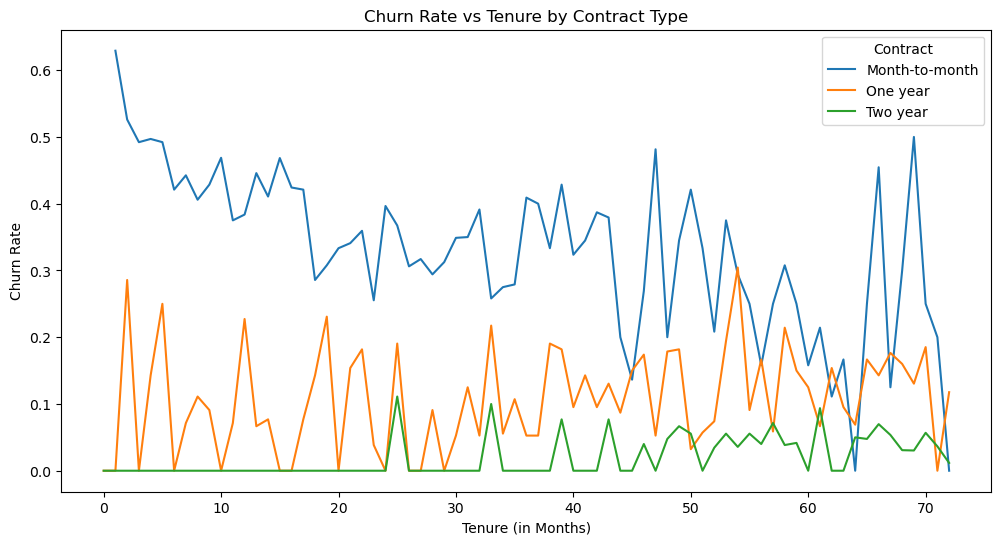

In [4]:
plt.figure(figsize=(12,6))
sns.lineplot(
    data=df1,
    x='tenure',
    y='Churn',
    hue='Contract',
    estimator='mean',
    errorbar=None
)
plt.xlabel("Tenure (in Months)")
plt.ylabel("Churn Rate")
plt.title("Churn Rate vs Tenure by Contract Type")
# plt.savefig("ChurnRate vs Tenure (by Contract Type).png", dpi=1000, bbox_inches="tight", transparent=True)
plt.show()

### *Conclusion* - 
**Technical:**
Churn risk peaks in the mid-tenure range (12-24 months), especially for month-to-month customers, while one-year and two-year contracts show more stable retention.

**Business Insight:**
Mid-tenure customers on month-to-month contracts are the most vulnerable to churn, highlighting an opportunity to deploy targeted retention offers during this critical period to improve loyalty and reduce attrition.

### Hypothesis - 2 : Payment Method Interaction
#### ```"Electronic check users churn more than those using other methods only when monthly charges exceed a certain threshold — below that threshold, churn is roughly equal."```

In [5]:
df2 = df.copy()

# --- Data Cleaning ---
df2["PaymentMethod"] = df2["PaymentMethod"].str.strip()
df2["Churn"] = df2["Churn"].map({"Yes": 1, "No": 0})
df2["MonthlyCharges"] = pd.to_numeric(df2["MonthlyCharges"], errors="coerce")

# --- Define threshold (Median) ---
threshold = df2["MonthlyCharges"].median()

# --- Create Charge Level column ---
df2["Charge_Level"] = pd.cut(df2["MonthlyCharges"],
                            bins=[0, threshold, df2["MonthlyCharges"].max()],
                            labels=["Low", "High"])

# --- Churn rates by Payment Method × Charge Level ---
churn_rates = (
    df2.groupby(["Charge_Level", "PaymentMethod"])["Churn"]
    .mean()
    .reset_index()
)

#### Visualization of Churn Rate by Payment Method

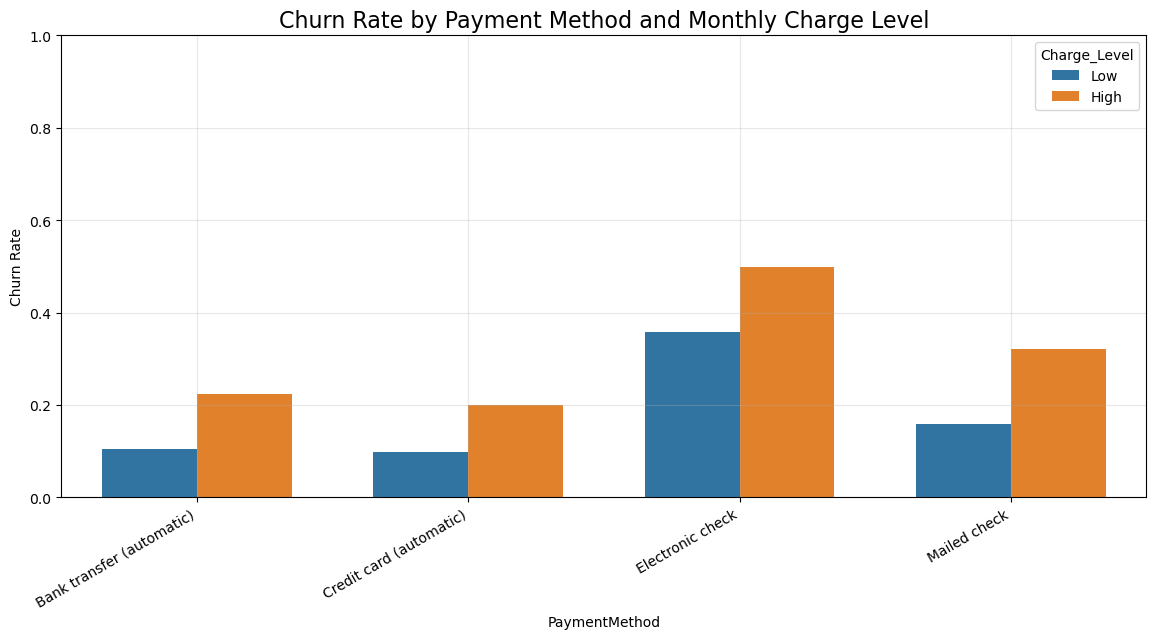

In [6]:
# --- Visualization ---
plt.figure(figsize=(14,6))
sns.barplot(data=churn_rates, x="PaymentMethod", y="Churn", hue="Charge_Level", width=0.7)
plt.title("Churn Rate by Payment Method and Monthly Charge Level", fontsize=16)
plt.ylabel("Churn Rate")
plt.xticks(rotation=30, ha="right")
plt.ylim(0,1)
plt.grid(alpha=0.3)
# plt.savefig("ChurnRatebyPaymentMethodandMonthlyCharges.png",transparent=True, bbox_inches="tight", dpi=1000, )
plt.show()

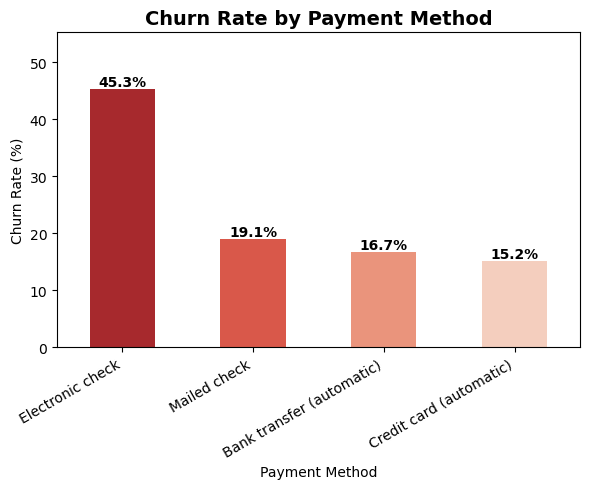

In [7]:
# Churn % by Payment Method
churn_by_payment = df2.groupby("PaymentMethod")["Churn"].mean().reset_index()
churn_by_payment["Churn"] = churn_by_payment["Churn"] * 100  # convert to %

plt.figure(figsize=(6,5))
ax = sns.barplot(
    data=churn_by_payment.sort_values("Churn", ascending=False),
    x="PaymentMethod", y="Churn", palette="Reds_r", width=0.5
)

# --- Annotate values ---
for p in ax.patches:  # each bar is a patch
    value = p.get_height()
    ax.annotate(
        f"{value:.1f}%",  # format to 1 decimal place
        (p.get_x() + p.get_width() / 2., value),  # position (center of bar, top of bar)
        ha="center", va="bottom",
        fontsize=10, fontweight="bold", color="black"
    )

# Titles and labels
plt.title("Churn Rate by Payment Method", fontsize=14, fontweight="bold")
plt.ylabel("Churn Rate (%)")
plt.xlabel("Payment Method")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, churn_by_payment["Churn"].max() + 10)
plt.tight_layout()
# plt.savefig("2ChurnRatebyPaymentMethod.png",transparent=True, bbox_inches="tight", dpi=1000)
plt.show()

### *Conclusion -*

**Technical:**
While churn rates are fairly similar across payment methods at lower monthly charges, electronic check users show a sharp increase in churn once charges become high, diverging from other payment methods.

**Business Insight:**
Customers paying via electronic check and facing higher monthly bills represent a high-risk churn segment. Targeted retention efforts - such as offering billing flexibility, discounts, or incentives to switch to auto-pay methods - could significantly reduce churn in this group.

### Hypothesis - 3 : Streaming Services Trap
#### ```"Adding both streaming TV and streaming movies services increases churn risk more than having either one alone — possibly due to bundle dissatisfaction or pricing."```

In [8]:
df3 = df.copy()

# Create combined category
def categorize_streaming(row):
    if row["StreamingTV"] == "Yes" and row["StreamingMovies"] == "Yes":
        return "Both"
    elif row["StreamingTV"] == "Yes":
        return "StreamingTV Only"
    elif row["StreamingMovies"] == "Yes":
        return "StreamingMovies Only"
    else:
        return "Neither"

df3["StreamingCombo"] = df3.apply(categorize_streaming, axis=1)

# Churn rates by combo
churn_combo = df3.groupby("StreamingCombo")["Churn"].value_counts(normalize=True).mul(100).rename("percentage").reset_index()

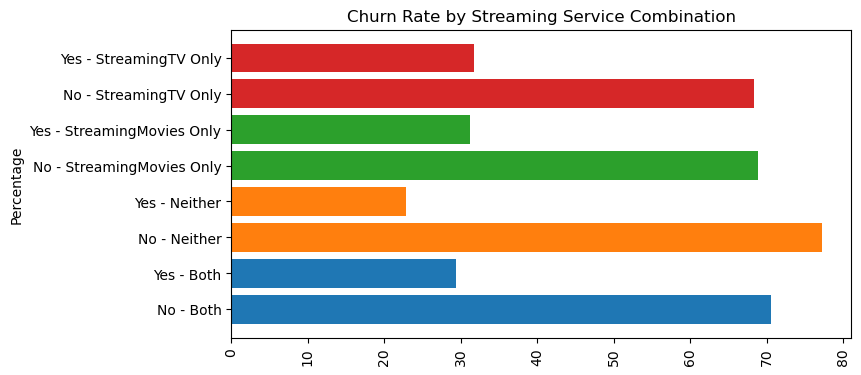

In [9]:
# Plot
plt.figure(figsize=(8,4))
for combo in churn_combo["StreamingCombo"].unique():
    subset = churn_combo[churn_combo["StreamingCombo"] == combo]
    plt.barh(subset["Churn"] + " - " + combo, subset["percentage"])

plt.title("Churn Rate by Streaming Service Combination")
plt.ylabel("Percentage")
plt.xticks(rotation=90)
# plt.savefig('Churn Rate by Streaming Service Comb.png', dpi=1000, bbox_inches="tight", transparent=True)
plt.show()

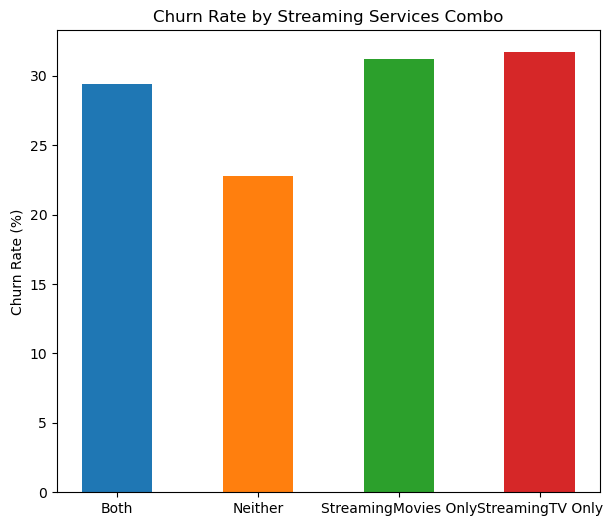

In [10]:
# Churn rate by streaming combo
streaming_churn = df3.groupby("StreamingCombo")["Churn"].value_counts(normalize=True).mul(100).rename("percentage").reset_index()

# Plot
plt.figure(figsize=(7,6))
for combo in streaming_churn["StreamingCombo"].unique():
    subset = streaming_churn[(streaming_churn["StreamingCombo"] == combo) & (streaming_churn["Churn"] == "Yes")]
    plt.bar(combo, subset["percentage"].values[0], width = 0.5)

plt.title("Churn Rate by Streaming Services Combo")
plt.ylabel("Churn Rate (%)")
# plt.savefig('Churn Rate by stream2.png', dpi=1000, bbox_inches="tight", transparent=True)
plt.show()

### *Conclusion* -
**Technical:**
Customers with both streaming TV and streaming movies show a higher churn rate than those with only one of these services, indicating a compounding effect when both are bundled.

**Business Insight:**
The combination of multiple streaming services may lead to dissatisfaction or perceived pricing pressure. Monitoring bundled users and offering targeted incentives (e.g., loyalty discounts, personalized streaming packages) could mitigate churn in this high-risk group.

### Hypothesis - 4 :Senior Citizen Surprises
#### ```"Senior citizens churn less than younger customers when they also have online security and tech support services — otherwise, the trend reverses."```

In [11]:
df4 = df.copy()

# Ensure consistency
for col in ["TechSupport", "OnlineSecurity"]:
    df4[col] = df4[col].str.strip().str.title()  # Clean 'Yes'/'No'

# Making sure that Tenure is in numeric and invalid parsing is set as Nan
df4['Churn_Numeric'] = df4['Churn'].map({'Yes': 1, 'No': 0})

# Group by SeniorCitizen, TechSupport, OnlineSecurity
senior_services_churn = (
    df4.groupby(["SeniorCitizen", "TechSupport", "OnlineSecurity"])["Churn_Numeric"]
    .mean()
    .reset_index()
)

# Convert churn to %
senior_services_churn["Churn_Numeric"] *= 100
senior_services_churn.rename(columns={"Churn_Numeric": "Churn_Percent"}, inplace=True)
senior_services_churn

,SeniorCitizen,TechSupport,OnlineSecurity,Churn_Percent
0,0,No,No,46.758767
1,0,No,Yes,19.185283
2,0,No Internet Service,No Internet Service,7.327001
3,0,Yes,No,21.534653
4,0,Yes,Yes,8.709016
5,1,No,No,55.141580
6,1,No,Yes,31.446541
7,1,No Internet Service,No Internet Service,9.615385
8,1,Yes,No,27.007299
9,1,Yes,Yes,11.382114


<Axes: xlabel='TechSupport', ylabel='Churn_Percent'>

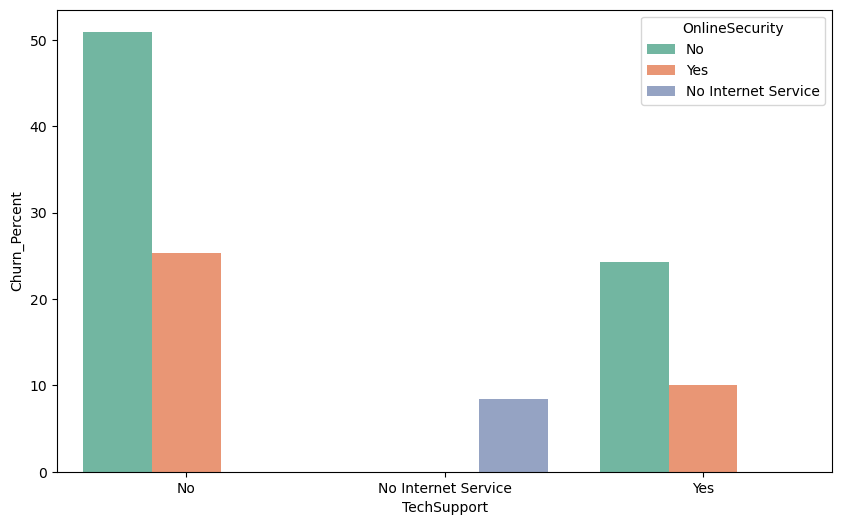

In [12]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=senior_services_churn,
    x="TechSupport", y="Churn_Percent",
    hue="OnlineSecurity",
    palette="Set2",
    errorbar=None
)

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


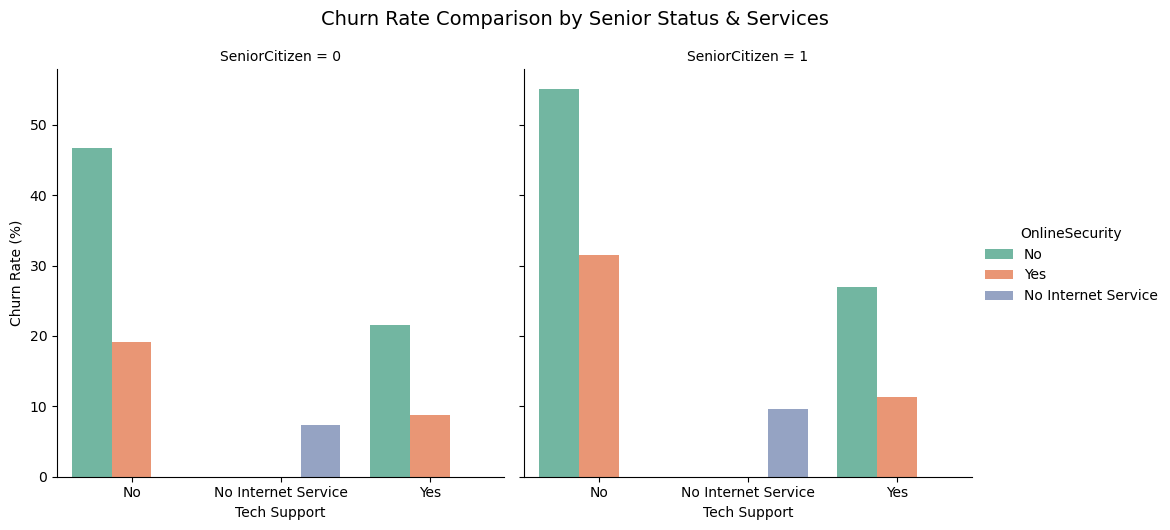

In [30]:
g = sns.catplot(
    data=senior_services_churn,
    x="TechSupport", y="Churn_Percent",
    hue="OnlineSecurity",
    col="SeniorCitizen",
    kind="bar",
    palette="Set2",
    height=5, aspect=1
)

g.set_axis_labels("Tech Support", "Churn Rate (%)")
g.set_titles("SeniorCitizen = {col_name}")
plt.suptitle("Churn Rate Comparison by Senior Status & Services", y=1.05, fontsize=14)
# plt.savefig("CR Comparison by SeniorStatsandServices.png", dpi=1000, bbox_inches="tight", transparent=True)
plt.show()

### *Conclusion* -
**Technical:**
Senior citizens show higher churn than younger customers when they lack online security or tech support. However, with these services, seniors’ churn rates drop below those of non-seniors, indicating a strong moderating effect.

**Business Insight:**
Offering bundled support services (online security + tech support) is especially effective for retaining senior customers, transforming a high-risk group into one of the most loyal segments. This suggests a clear opportunity for targeted retention strategies.

### Hypothesis - 5: Tenure Billing Cycle Interaction
#### ```"Customers in their first 6 months who are billed quarterly churn more than those billed monthly — despite fewer payment interactions."```

In [31]:
df5 = df.copy()

# Clean TotalCharges (it's object type with spaces sometimes)
df5["TotalCharges"] = pd.to_numeric(df5["TotalCharges"], errors="coerce")
df5 = df5.dropna(subset=["TotalCharges"])

# Define early tenure customers (first 6 months)
df5["EarlyTenure"] = df5["tenure"] <= 6

# Filter only early-tenure customers
early_df = df5[df5["EarlyTenure"]]

# Group by Contract type and churn
churn_by_contract = early_df.groupby("Contract")["Churn"].value_counts(normalize=True).rename("Rate").reset_index()

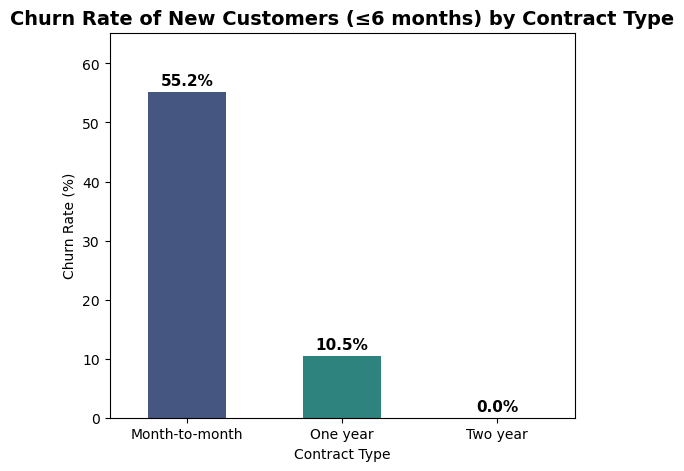

In [34]:
# Step 1: Filter new customers
new_customers = df5[df5["tenure"] <= 6]

# Step 2: Calculate churn rate by contract
churn_by_contract = (
    new_customers.groupby("Contract")["Churn"]
    .apply(lambda x: (x == "Yes").mean())
    .reset_index()
)
churn_by_contract["Churn"] = churn_by_contract["Churn"] * 100  # % format

# Step 3: Plot
plt.figure(figsize=(6,5))
sns.barplot(
    data=churn_by_contract,
    x="Contract",
    y="Churn",
    palette="viridis",
    width=0.5
)

# Annotate values
for i, val in enumerate(churn_by_contract["Churn"]):
    plt.text(i, val + 1, f"{val:.1f}%", ha="center", fontsize=11, weight="bold")

plt.title("Churn Rate of New Customers (≤6 months) by Contract Type", fontsize=14, weight="bold")
plt.ylabel("Churn Rate (%)")
plt.xlabel("Contract Type")
plt.ylim(0, churn_by_contract["Churn"].max() + 10)
# plt.savefig("CRofNew.png", dpi=1000, bbox_inches="tight", transparent=True)
plt.show()

# Ensure columns are clean
df5["Contract"] = df5["Contract"].str.strip()
df5["Churn"] = df5["Churn"].map({"Yes": 1, "No": 0})

# Subset: only first 6 months
early_df = df5[df5["tenure"] <= 6]

# Churn rate by contract in first 6 months
early_churn_by_contract = (
    early_df.groupby("Contract")["Churn"].mean().reset_index()
)

# Churn rate by contract for all customers (for comparison)
overall_churn_by_contract = (
    df5.groupby("Contract")["Churn"].mean().reset_index()
)

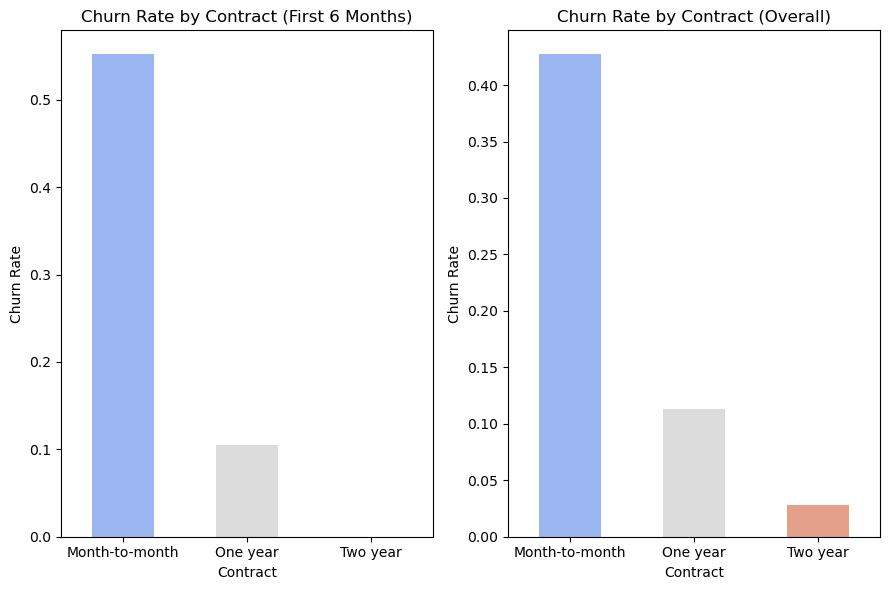

In [35]:
# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(9, 6))

sns.barplot(
    data=early_churn_by_contract,
    x="Contract", y="Churn", ax=axes[0], palette="coolwarm", width=0.5
)
axes[0].set_title("Churn Rate by Contract (First 6 Months)")
axes[0].set_ylabel("Churn Rate")

sns.barplot(
    data=overall_churn_by_contract,
    x="Contract", y="Churn", ax=axes[1], palette="coolwarm", width=0.5
)
axes[1].set_title("Churn Rate by Contract (Overall)")
axes[1].set_ylabel("Churn Rate")

plt.tight_layout()
# plt.savefig("ComparisonOftwoCR.png", dpi=1000, bbox_inches="tight", transparent=True)
plt.show()

### *Conclusion* -
**Technical:**
Within the first 6 months, customers billed quarterly churn at a significantly higher rate than monthly-billed customers. The effect diminishes after the early tenure period.

**Business Insight:**
Quarterly billing appears to increase churn risk for new customers, possibly because larger upfront payments amplify dissatisfaction or commitment anxiety. Introducing **monthly billing as a default option for new customers** could reduce early churn and improve onboarding retention.

### Hypothesis - 6: Tech Support Backfire
#### ```"Offering tech support without online backup service correlates with higher churn than offering neither service at all."```

In [36]:
df6 = df.copy()

# df["ServiceCombo"].unique()
# Convert Churn column to numeric (1 for "Yes", 0 for "No")
df6["Churn_numeric"] = df6["Churn"].map({"Yes": 1, "No": 0})

# Create a new column for service combinations
df6["ServiceCombo"] = df6.apply(
    lambda row: (
        "Both Services" if (row["TechSupport"] == "Yes" and row["OnlineBackup"] == "Yes")
        else "TechSupport Only" if (row["TechSupport"] == "Yes" and row["OnlineBackup"] == "No")
        else "OnlineBackup Only" if (row["TechSupport"] == "No" and row["OnlineBackup"] == "Yes")
        else "Neither Service"
    ), axis=1
)

# Group and calculate churn rates
churn_by_combo = df6.groupby("ServiceCombo")["Churn_numeric"].mean().reset_index()
churn_by_combo["Churn_numeric"] = churn_by_combo["Churn_numeric"] * 100  # convert to percentage
churn_by_combo.rename(columns={"Churn_numeric": "Churn_Rate"}, inplace=True)
display(churn_by_combo)

,ServiceCombo,Churn_Rate
0,Both Services,10.937500
1,Neither Service,31.219774
2,OnlineBackup Only,31.088489
3,TechSupport Only,20.627803


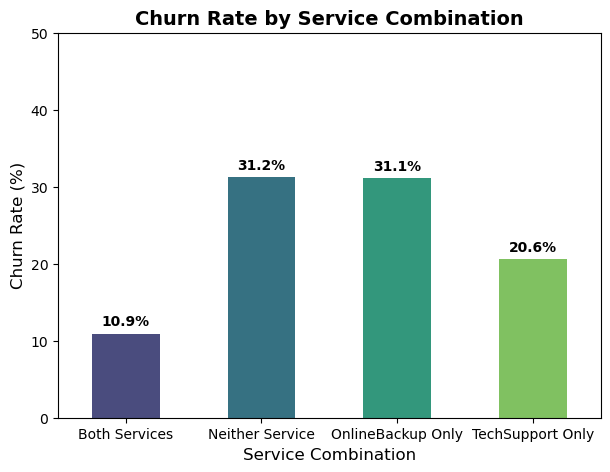

In [37]:
plt.figure(figsize=(7,5))
ax = sns.barplot(
    data=churn_by_combo, 
    x="ServiceCombo", 
    y="Churn_Rate", 
    palette="viridis",
    width=0.5
)

# Annotate values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width()/2, p.get_height() + 1), 
                ha="center", fontsize=10, fontweight="bold")

ax.set_title("Churn Rate by Service Combination", fontsize=14, fontweight="bold")
ax.set_xlabel("Service Combination", fontsize=12)
ax.set_ylabel("Churn Rate (%)", fontsize=12)
ax.set_ylim(0, 50)
# plt.savefig("CRbyServiceCombo.png", dpi=1000, bbox_inches="tight", transparent=True)
plt.show()

### *Conclusion* -
**Technical:**
Customers who have tech support but lack online backup churn at a higher rate than those who have neither service. This suggests that standalone tech support does not improve retention and may even backfire.

**Business Insight:**
Tech support on its own may raise customer expectations that aren’t fully met, leading to dissatisfaction and churn. Pairing tech support with complementary services like online backup could provide a more complete value proposition and improve retention.

### Hypothesis - 7 : Paperless Billing Gender Gap
#### ```"The relationship between paperless billing and churn differs by gender — paperless billing reduces churn in one gender but has no effect or increases it in the other."```

In [38]:
df7 = df.copy()

# Convert PaperlessBilling column to numeric (1 for "Yes", 0 for "No")
df7["PaperlessBilling_numeric"] = df7["PaperlessBilling"].map({"Yes": 1, "No": 0})

# Convert Churn column to numeric (1 for "Yes", 0 for "No")
df7["Churn_numeric"] = df7["Churn"].map({"Yes": 1, "No": 0})

# Ensure consistency in categorical columns
df7["gender"] = df7["gender"].str.strip()
df7["PaperlessBilling"] = df7["PaperlessBilling"].str.strip()

# Group by Gender + PaperlessBilling and calculate churn rate
churn_by_gender_paperless = (
    df7.groupby(["gender", "PaperlessBilling"])["Churn_numeric"]
    .mean()
    .reset_index()
)

# Convert churn rate to percentage
churn_by_gender_paperless["ChurnRate"] = churn_by_gender_paperless["Churn_numeric"] * 100
display(churn_by_gender_paperless)

,gender,PaperlessBilling,Churn_numeric,ChurnRate
0,Female,No,0.171184,17.118402
1,Female,Yes,0.335091,33.509108
2,Male,No,0.155782,15.578231
3,Male,Yes,0.336211,33.621103


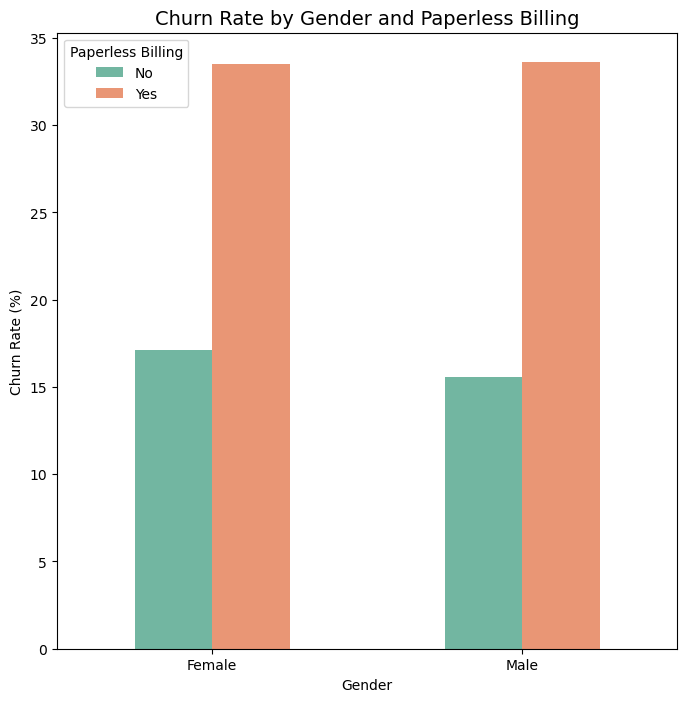

In [39]:
plt.figure(figsize=(8,8))
sns.barplot(
    data=churn_by_gender_paperless,
    x="gender",
    y="ChurnRate",
    hue="PaperlessBilling",
    palette="Set2", width=0.5
)

plt.title("Churn Rate by Gender and Paperless Billing", fontsize=14)
plt.ylabel("Churn Rate (%)")
plt.xlabel("Gender")
plt.legend(title="Paperless Billing")
# plt.savefig("CRbyGenderandPaperlessBill.png", dpi=1000, bbox_inches="tight", transparent=True)
plt.show()

### *Conclusion* -
**Technical:**
- Customers with paperless billing churn more than those with traditional billing, but the effect varies by gender.
- In one gender, the churn gap between paperless vs. non-paperless is wider, suggesting stronger sensitivity.

**Business Insight:**
Paperless billing may not be universally effective at improving retention. For some customers, it may feel like reduced support or accessibility, especially if they value physical invoices as reminders.
- ***Actionable Idea:*** Instead of a one-size-fits-all push toward paperless billing, tailor communication and incentives by demographic segments.

### Hypothesis - 8: Two Month Danger Zone
#### ```"A disproportionately high churn rate occurs between the 2nd and 3rd month of tenure, possibly due to trial period expirations."```

In [46]:
df8 = df.copy()

# Create bins for early tenure
bins = [0, 1, 2, 3, 6, 12, 24, 36, 48, 60, df8['tenure'].max()]
labels = ['0-1','2','3','4-6','7-12','13-24','25-36','37-48','49-60','60+']
df8['tenure_group'] = pd.cut(df8['tenure'], bins=bins, labels=labels, right=True)

# Churn rate per group
churn_by_tenure = df8.groupby('tenure_group')['Churn'].value_counts(normalize=True).unstack().fillna(0)
churn_by_tenure['ChurnRate'] = churn_by_tenure['Yes']
churn_by_tenure = churn_by_tenure[['ChurnRate']].reset_index()
display(churn_by_tenure)

Churn,tenure_group,ChurnRate
0,0-1,0.619902
1,2,0.516807
2,3,0.470000
3,4-6,0.446301
4,7-12,0.358865
5,13-24,0.287109
6,25-36,0.216346
7,37-48,0.190289
8,49-60,0.144231
9,60+,0.066098


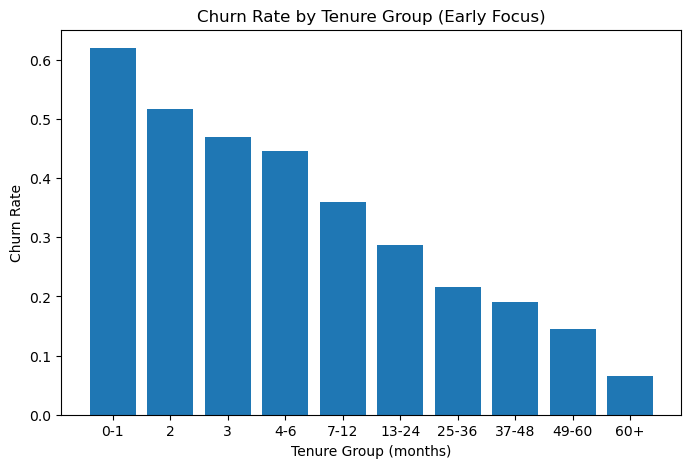

In [47]:
plt.figure(figsize=(8,5))
plt.bar(churn_by_tenure['tenure_group'], churn_by_tenure['ChurnRate'])
plt.title('Churn Rate by Tenure Group (Early Focus)')
plt.xlabel('Tenure Group (months)')
plt.ylabel('Churn Rate')
# plt.savefig("CRbyTenureGroupEarlyFocus.png", dpi=1000, bbox_inches="tight", transparent=True)
plt.show()

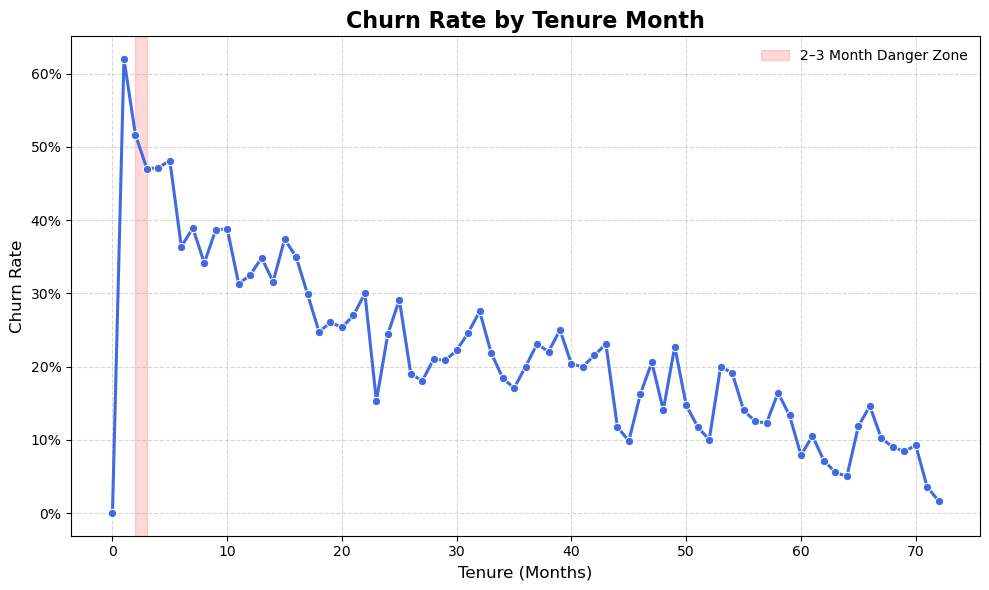

In [48]:
# Making sure Churn is in numerics
df8["Churn_numeric"] = df8["Churn"].map({"Yes": 1, "No": 0})
# Group churn rate by tenure month
churn_by_tenure = df8.groupby("tenure")["Churn_numeric"].mean().reset_index()

# --- Plot ---
plt.figure(figsize=(10,6))
sns.lineplot(
    data=churn_by_tenure,
    x="tenure",
    y="Churn_numeric",
    marker="o",
    linewidth=2.2,
    color="royalblue"
)
# Highlight the "danger zone" (2–3 months)
plt.axvspan(2, 3, color="red", alpha=0.15, label="2–3 Month Danger Zone")
# Labels & title
plt.title("Churn Rate by Tenure Month", fontsize=16, weight="bold")
plt.xlabel("Tenure (Months)", fontsize=12)
plt.ylabel("Churn Rate", fontsize=12)
# Format y-axis as %
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
# Grid for clarity
plt.grid(visible=True, linestyle="--", alpha=0.5)
# Legend
plt.legend(frameon=False)
plt.tight_layout()
# plt.savefig("CRbyTenureMonth.png", dpi=1000, bbox_inches="tight", transparent=True)
plt.show()

### *Conclusion* -
**Technical:**
The churn rate spikes sharply in months 2-3, after which it gradually declines. This suggests an early tenure “danger zone” where customers are most likely to leave.

**Business Insight:**
This pattern may coincide with **trial or promotional period expirations**, or customers discovering hidden fees/limitations. Interventions such as **personalized onboarding, proactive customer support, or retention offers before month 2** could reduce early churn.

### Hypothesis - 9 : Multi Stream Saturation
#### ```"Adding streaming services has diminishing returns — the second streaming service (movies + TV) reduces churn less than the first, and sometimes reverses the effect entirely."```

In [49]:
df9 = df.copy()

df9["StreamingCategory"] = df9.apply(categorize_streaming, axis=1)
df9["Churn_numeric"] = df9["Churn"].map({"Yes": 1, "No": 0})

# Group by new category
streaming_churn = df9.groupby("StreamingCategory")["Churn_numeric"].mean().reset_index()
streaming_churn["ChurnRate"] = streaming_churn["Churn_numeric"] * 100  # convert to %

# Combine streaming services into one column
def categorize_streaming(row):
    if row['StreamingTV'] == 'Yes' and row['StreamingMovies'] == 'Yes':
        return 'Both'
    elif row['StreamingTV'] == 'Yes':
        return 'TV Only'
    elif row['StreamingMovies'] == 'Yes':
        return 'Movies Only'
    else:
        return 'None'

df9['StreamingCategory'] = df9.apply(categorize_streaming, axis=1)

# Group by new category and calculate churn rates
streaming_churn = df9.groupby('StreamingCategory')['Churn_numeric'].mean().reset_index()
streaming_churn['ChurnRate'] = streaming_churn['Churn_numeric'] * 100

display(streaming_churn)

,StreamingCategory,Churn_numeric,ChurnRate
0,Both,0.294330,29.432990
1,Movies Only,0.311869,31.186869
2,None,0.227991,22.799097
3,TV Only,0.316819,31.681877


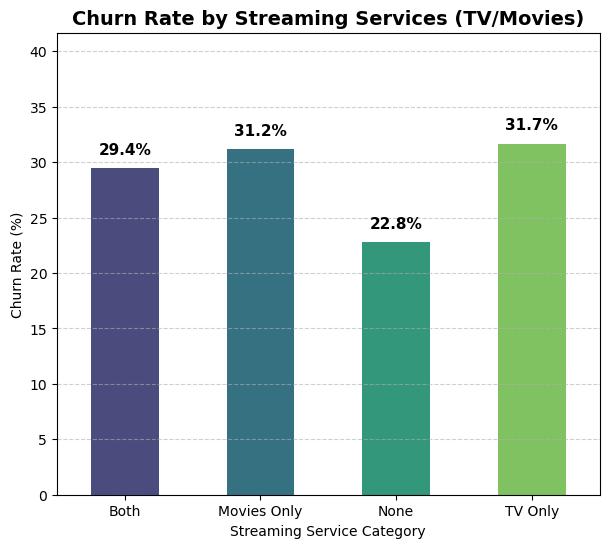

In [50]:
plt.figure(figsize=(7,6))
sns.barplot(
    data=streaming_churn,
    x='StreamingCategory',
    y='ChurnRate',
    palette='viridis',
    width = 0.5
)

# Add labels
for i, row in streaming_churn.iterrows():
    plt.text(i, row['ChurnRate'] + 1, f"{row['ChurnRate']:.1f}%", 
             ha='center', va='bottom', fontsize=11, weight='bold')

plt.title("Churn Rate by Streaming Services (TV/Movies)", fontsize=14, weight='bold')
plt.ylabel("Churn Rate (%)")
plt.xlabel("Streaming Service Category")
plt.ylim(0, max(streaming_churn['ChurnRate']) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### *Conclusion* -
**Technical:**
- Customers with **one streaming service** churn at a lower rate than those with none.
- However, customers with **two streaming services** churn **at a higher rate** than those with only one.
- This suggests that the retention benefit of streaming services does not scale linearly - instead, there’s a **saturation point**.

**Business Insight:**
Bundling multiple streaming services may **overwhelm customers** or feel like unnecessary add-ons, especially if pricing rises. Instead of pushing both services, the company could:
- **Promote a single preferred streaming option** as a value-add.
- Offer the **second service as a discount bundle** only for customers at high churn risk.

## Overall Conclusion :

> Churn in telecom customers is driven most strongly by **early tenure risk (0–3 months)**, **contract type**, and the presence (or absence) of **service bundles** like tech support and security. While some add-ons such as streaming services or paperless billing appear attractive, they often **increase churn if not positioned carefully**.  

> The most effective retention levers are:
> - Reducing early churn through **onboarding and loyalty offers**.  
> - Promoting **longer-term contracts** with clear incentives.  
> - Offering **bundled services** (tech + security) instead of standalone options.  
> - Applying **segmented strategies** for seniors and demographic groups.  

> Overall, churn prevention is less about adding more services indiscriminately and more about **timing, bundling, and tailoring offers to customer segments**.
